<br>

# Dados Tabulares

In [1]:
import os
import py7zr
import requests
import pandas as pd
import geopandas as gpd

from osgeo import ogr
from zipfile import ZipFile

In [2]:
from paths import *
from functions import *

<br>

## Get Data

In [3]:
# Input
url = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/UFs/SP/SP_Municipios_2020.zip'
filename = 'sp_ibge_250k.zip'

# Get Data
get_download(url, filename, shps_path)
unzip(filename, shps_path)

File "sp_ibge_250k.zip" download in "../data/shps" directory.
File "SP_Municipios_2020.cpg" extracted as "sp_ibge_250k.cpg" in "../data/shps" directory.
File "SP_Municipios_2020.dbf" extracted as "sp_ibge_250k.dbf" in "../data/shps" directory.
File "SP_Municipios_2020.prj" extracted as "sp_ibge_250k.prj" in "../data/shps" directory.
File "SP_Municipios_2020.shp" extracted as "sp_ibge_250k.shp" in "../data/shps" directory.
File "SP_Municipios_2020.shx" extracted as "sp_ibge_250k.shx" in "../data/shps" directory.


In [4]:
# Input
url = 'http://datageo.ambiente.sp.gov.br/geoserver/datageo/LimiteMunicipal/wfs?version=1.0.0&request=GetFeature&outputFormat=SHAPE-ZIP&typeName=LimiteMunicipal'
filename = 'sp_igc_050k.zip'

# Get Data
get_download(url, filename, shps_path)
unzip(filename, shps_path)

File "sp_igc_050k.zip" download in "../data/shps" directory.
File "LimiteMunicipalPolygon.cst" extracted as "sp_igc_050k.cst" in "../data/shps" directory.
File "LimiteMunicipalPolygon.prj" extracted as "sp_igc_050k.prj" in "../data/shps" directory.
File "LimiteMunicipalPolygon.dbf" extracted as "sp_igc_050k.dbf" in "../data/shps" directory.
File "LimiteMunicipalPolygon.shp" extracted as "sp_igc_050k.shp" in "../data/shps" directory.
File "LimiteMunicipalPolygon.shx" extracted as "sp_igc_050k.shx" in "../data/shps" directory.
File "wfsrequest.txt" extracted as "sp_igc_050k.txt" in "../data/shps" directory.


<br>

## Área

In [5]:
# Converte em *geojson*
file = 'sp_ibge_250k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Deleta colunas
gdf.drop([
    'NM_MUN',
    'SIGLA_UF',
],
    axis=1,
    inplace=True
)

# Renomeia colunas
gdf.rename(
    columns={
        'CD_MUN': 'id_municipio',
        'AREA_KM2': 'area_km2',
    },
    inplace=True
)

# Ajusta Tipo
gdf['id_municipio'] = gdf['id_municipio'].astype(int)

# Create Dataframe
df = gdf[['id_municipio', 'area_km2']]

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_area.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,area_km2
0,3500105,411.987
1,3500204,211.055
2,3500303,474.554
3,3500402,142.673
4,3500501,60.126


<br>

## CETESB

In [6]:
# Lê arquivo
file = 'sp_igc_050k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Cria Cópia
df = gdf

# Renomeia colunas
df.rename(
    columns={
        'Cod_ibge'  : 'id_municipio',
        'Cod_Cetesb': 'id_cetesb',
    },
    inplace=True
)

# Seleciona
df = df[['id_municipio', 'id_cetesb']].copy()

In [7]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome'],
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='left',
    left_on='id_municipio',
    right_on='id_municipio',
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_idcetesb.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,id_cetesb
0,3500105,Adamantina,150
1,3500204,Adolfo,151
2,3500303,Aguaí,152
3,3500402,Águas da Prata,154
4,3500501,Águas de Lindóia,153


<br>

## UGRHIs

In [8]:
def rename_nome(x):
    x = x.title()
    x = x.strip()
    dict_rename = {
        # Encoding
        '/': ' / ',
        '  '  : ' ',
        ' De '  : ' de ',
        ' Da '  : ' da ',
        ' Do '  : ' do ',
        ' Dos '  : ' dos ',
        'Jundiai'  : 'Jundiaí',        
    }
    for k, v in dict_rename.items():
        x = x.replace(k, v)
    x = x.replace('  ', ' ')
    return x.strip()

In [9]:
# Lê arquivo
file = 'sp_igc_050k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Cria Cópia
df = gdf

# Renomeia colunas
df.rename(
    columns={
        'Cod_ibge'  : 'id_municipio',
        'Nome_ugrhi': 'nome_ugrhi',
        'UGRHI'     : 'id_ugrhi',
    },
    inplace=True
)

# Seleciona
df = df[['id_municipio', 'id_ugrhi', 'nome_ugrhi']].copy()

# Renomeia Campos Coluna
df.loc[:, 'nome_ugrhi'] = df['nome_ugrhi'].astype(str).apply(lambda x: rename_nome(x))

# Resultados
df.head()

,id_municipio,id_ugrhi,nome_ugrhi
0,3500105,21,Peixe
1,3500204,16,Tietê / Batalha
2,3500303,9,Mogi-Guaçu
3,3500402,9,Mogi-Guaçu
4,3500501,9,Mogi-Guaçu


In [10]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='left',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_ugrhi.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,id_ugrhi,nome_ugrhi
0,3500105,Adamantina,21,Peixe
1,3500204,Adolfo,16,Tietê / Batalha
2,3500303,Aguaí,9,Mogi-Guaçu
3,3500402,Águas da Prata,9,Mogi-Guaçu
4,3500501,Águas de Lindóia,9,Mogi-Guaçu


<br>

## RMs e AUs

In [11]:
# URL para baixar o arquivo zip
url = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/estrutura_territorial/municipios_por_regioes_metropolitanas/Situacao_2020a2029/Composicao_RMs_RIDEs_AglomUrbanas_2020_06_30.xlsx'

# Read File
df = pd.read_excel(
    url,
    engine='openpyxl',
)
print('Existem as seguintes colunas disponíveis:\n{}\n'.format(list(df.columns)))

df = df.loc[df['COD_UF'] == 35]
df = df[['COD_MUN', 'NOME', 'LEG', 'DATA']].copy()
df.reset_index(drop=True, inplace=True)

df.rename(
    columns={
        'COD_MUN': 'id_municipio',
        'NOME'   : 'nome_rm',
        'LEG'    : 'legislacao',
        'DATA'   : 'data',
    },
    inplace=True,
)

# Atribute Table
df['data_format'] = df['data'].dt.strftime('%d.%m.%Y')
df['legislacao_data'] = df[['legislacao', 'data_format']].apply(lambda x: ' de '.join(x), axis=1)
df.drop('data_format', axis=1, inplace=True)

Existem as seguintes colunas disponíveis:
['GRANDE_REG', 'COD_UF', 'SIGLA_UF', 'COD', 'NOME', 'TIPO', 'COD_CAT_ASSOC', 'CAT_ASSOC', 'COD_MUN', 'NOME_MUN', 'LEG', 'DATA']



In [12]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='right',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Results
df.to_csv(
    os.path.join(tabs_path, 'tab_rms.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,nome_rm,legislacao,data,legislacao_data
0,3503000,Aramina,Aglomeração Urbana de Franca,Lei Complementar 1.323,2018-05-22,Lei Complementar 1.323 de 22.05.2018
1,3508207,Buritizal,Aglomeração Urbana de Franca,Lei Complementar 1.323,2018-05-22,Lei Complementar 1.323 de 22.05.2018
2,3513207,Cristais Paulista,Aglomeração Urbana de Franca,Lei Complementar 1.323,2018-05-22,Lei Complementar 1.323 de 22.05.2018
3,3516200,Franca,Aglomeração Urbana de Franca,Lei Complementar 1.323,2018-05-22,Lei Complementar 1.323 de 22.05.2018
4,3517406,Guaíra,Aglomeração Urbana de Franca,Lei Complementar 1.323,2018-05-22,Lei Complementar 1.323 de 22.05.2018


<br>

## Microregião

In [13]:
# Lê geojson
file = 'sp_ibge_250k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Cria Cópia
df = gdf[['CD_MUN']].copy()

# Renomeia colunas
df.rename(columns={'CD_MUN'  : 'id_municipio'}, inplace=True)

# Pega apenas os três primeiros caracteres de um campo de número de maneira mais eficiente
df['id_microregiao'] = [int(x[0:5]) for x in df['id_municipio']]

# Ajusta Tipo
df['id_municipio'] = df['id_municipio'].astype(int)

In [14]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='left',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_microregiao.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,id_microregiao
0,3500105,Adamantina,35001
1,3500204,Adolfo,35002
2,3500303,Aguaí,35003
3,3500402,Águas da Prata,35004
4,3500501,Águas de Lindóia,35005


<br>

## Mesoregião

In [15]:
# Lê geojson
file = 'sp_ibge_250k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Cria Cópia
df = gdf[['CD_MUN']].copy()

# Renomeia colunas
df.rename(columns={'CD_MUN'  : 'id_municipio'}, inplace=True)

# Pega apenas os três primeiros caracteres de um campo de número de maneira mais eficiente
df['id_mesoregiao'] = [int(x[0:4]) for x in df['id_municipio']]

# Ajusta Tipo
df['id_municipio'] = df['id_municipio'].astype(int)

In [16]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='left',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_mesoregiao.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,id_mesoregiao
0,3500105,Adamantina,3500
1,3500204,Adolfo,3500
2,3500303,Aguaí,3500
3,3500402,Águas da Prata,3500
4,3500501,Águas de Lindóia,3500


<br>

## Macrometropole

In [17]:
# Input
url = 'http://datageo.ambiente.sp.gov.br/geoserver/datageo/LimiteMacrometropole2015/wfs?version=1.0.0&request=GetFeature&outputFormat=SHAPE-ZIP&typeName=LimiteMacrometropole2015'
filename = 'sp_macrometropole.zip'

# Get Data
get_download(url, filename, shps_path)
unzip(filename, shps_path)

File "sp_macrometropole.zip" download in "../data/shps" directory.
File "LimiteMacrometropole2015Polygon.cst" extracted as "sp_macrometropole.cst" in "../data/shps" directory.
File "LimiteMacrometropole2015Polygon.dbf" extracted as "sp_macrometropole.dbf" in "../data/shps" directory.
File "LimiteMacrometropole2015Polygon.shp" extracted as "sp_macrometropole.shp" in "../data/shps" directory.
File "LimiteMacrometropole2015Polygon.shx" extracted as "sp_macrometropole.shx" in "../data/shps" directory.
File "LimiteMacrometropole2015Polygon.prj" extracted as "sp_macrometropole.prj" in "../data/shps" directory.
File "wfsrequest.txt" extracted as "sp_macrometropole.txt" in "../data/shps" directory.


In [18]:
# Lê arquivo
file = 'sp_macrometropole'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Transforma Coordenadas
gdf = gdf.to_crs(epsg=4326)

# Renomeia colunas
gdf.rename(columns={'Nome': 'macrometropole'}, inplace=True)

# Results
display(gdf.head())

# Cria Cópia
gdf_macro = gdf

# Deleta Shapefile
delete_shapefile(shp)

,macrometropole,geometry
0,Macrometrópole,"MULTIPOLYGON (((-45.52488 -23.85610, -45.52502..."


,id_municipio,geometry
0,3500105,POINT (-51.03455 -21.58238)
1,3500204,POINT (-49.64157 -21.28052)
2,3500303,POINT (-47.05263 -22.05743)
3,3500402,POINT (-46.70056 -21.91795)
4,3500501,POINT (-46.60940 -22.47578)


<AxesSubplot:>

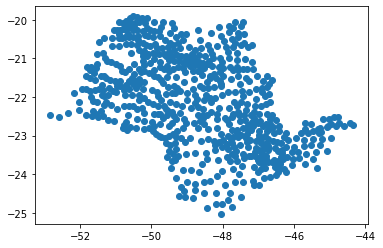

In [19]:
# Lê arquivo
file = 'sp_igc_050k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Renomeia colunas
gdf.rename(
    columns={
        'Cod_ibge'  : 'id_municipio',
        'Cod_Cetesb': 'id_cetesb',
        'Nome'      : 'nome_municipio',
        'Rotulo'    : 'rotulo_municipio',
        'Nome_ugrhi': 'nome_ugrhi',
        'UGRHI'     : 'id_ugrhi',
    },
    inplace=True
)

# Deleta colunas
gdf.drop(['id_cetesb', 'nome_municipio', 'rotulo_municipio', 'nome_ugrhi', 'id_ugrhi'], axis=1, inplace=True)

# Transforma Coordenadas
gdf = gdf.to_crs(epsg=4326)

# Pega centroid
gdf_geometry = gdf.representative_point()
gdf['geometry'] = gdf_geometry

# Results
display(gdf.head())
gdf.plot()

/home/michel/Documents/Conda/envs/pablocarreira-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id_municipio,macrometropole
6,3500600,Macrometrópole
8,3500758,Macrometrópole
13,3501152,Macrometrópole
18,3501608,Macrometrópole
22,3502002,Macrometrópole


<AxesSubplot:>

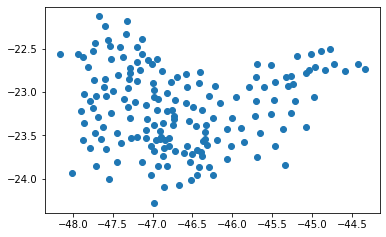

In [20]:
# Intersect
gdf_inter = gpd.sjoin(gdf, gdf_macro, how='inner', op='intersects')

# Convert to Dataframe
df = gdf_inter[['id_municipio', 'macrometropole']].copy()

# Results
display(df.head())
gdf_inter.plot()

In [21]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='right',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_macrometropole.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,macrometropole
0,3500600,Águas de São Pedro,Macrometrópole
1,3500758,Alambari,Macrometrópole
2,3501152,Alumínio,Macrometrópole
3,3501608,Americana,Macrometrópole
4,3502002,Analândia,Macrometrópole


<br>

## Regiões do Governo

In [22]:
# Input
url = 'http://datageo.ambiente.sp.gov.br/geoserver/datageo/RegioesGoverno/wfs?version=1.0.0&request=GetFeature&outputFormat=SHAPE-ZIP&typeName=RegioesGoverno'
filename = 'sp_regioesgoverno.zip'

# Get Data
get_download(url, filename, shps_path)
unzip(filename, shps_path)

File "sp_regioesgoverno.zip" download in "../data/shps" directory.
File "RegioesGovernoPolygon.cst" extracted as "sp_regioesgoverno.cst" in "../data/shps" directory.
File "RegioesGovernoPolygon.dbf" extracted as "sp_regioesgoverno.dbf" in "../data/shps" directory.
File "RegioesGovernoPolygon.prj" extracted as "sp_regioesgoverno.prj" in "../data/shps" directory.
File "RegioesGovernoPolygon.shx" extracted as "sp_regioesgoverno.shx" in "../data/shps" directory.
File "RegioesGovernoPolygon.shp" extracted as "sp_regioesgoverno.shp" in "../data/shps" directory.
File "wfsrequest.txt" extracted as "sp_regioesgoverno.txt" in "../data/shps" directory.


In [23]:
def rename_nome(x):
    x = x.title()
    x = x.strip()
    dict_rename = {
        '  '  : ' ',
        ' De '  : ' de ',
        ' Da '  : ' da ',
        ' Do '  : ' do ',
        ' Dos '  : ' dos ',        
        ' Jose '  : ' José ',
        ' Joao '  : ' João ',
        'Jau'  : 'Jaú',
        'Sao ': 'São ',
        'Avare': 'Avaré',
        'Jundiai': 'Jundiaí',
        'Marilia': 'Marília',
        'Taubate': 'Taubaté',
        'Ribeirao': 'Ribeirão',
        'Guaratingueta': 'Guaratinguetá',
        'Fernandopolis': 'Fernandópolis',
    }
    for k, v in dict_rename.items():
        x = x.replace(k, v)
    x = x.replace('  ', ' ')
    return x.strip()

In [24]:
# Lê arquivo
file = 'sp_regioesgoverno'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Transforma Coordenadas
gdf = gdf.to_crs(epsg=4326)

# Renomeia colunas
gdf.rename(columns={'Nome': 'regiaogoverno_nome'}, inplace=True)

# Renomeia Campos Coluna
gdf.loc[:, 'regiaogoverno_nome'] = gdf['regiaogoverno_nome'].astype(str).apply(lambda x: rename_nome(x))

# Results
display(gdf.head())

# Cria Cópia
gdf_gov = gdf

# Deleta Shapefile
delete_shapefile(shp)

,regiaogoverno_nome,geometry
0,Presidente Prudente,"POLYGON ((-51.96297 -21.51639, -51.96298 -21.5..."
1,Dracena,"POLYGON ((-51.76840 -21.05116, -51.76776 -21.0..."
2,Andradina,"POLYGON ((-51.10467 -20.28636, -51.10212 -20.2..."
3,Jales,"POLYGON ((-50.61453 -19.86751, -50.61469 -19.8..."
4,Adamantina,"POLYGON ((-51.32580 -21.29629, -51.32561 -21.2..."


,id_municipio,geometry
0,3500105,POINT (-51.03455 -21.58238)
1,3500204,POINT (-49.64157 -21.28052)
2,3500303,POINT (-47.05263 -22.05743)
3,3500402,POINT (-46.70056 -21.91795)
4,3500501,POINT (-46.60940 -22.47578)


<AxesSubplot:>

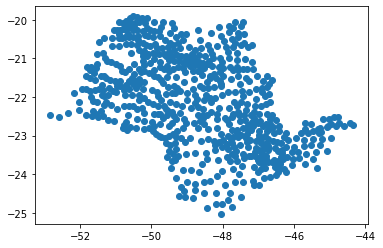

In [25]:
# Lê arquivo
file = 'sp_igc_050k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Renomeia colunas
gdf.rename(
    columns={
        'Cod_ibge'  : 'id_municipio',
        'Cod_Cetesb': 'id_cetesb',
        'Nome'      : 'nome_municipio',
        'Rotulo'    : 'rotulo_municipio',
        'Nome_ugrhi': 'nome_ugrhi',
        'UGRHI'     : 'id_ugrhi',
    },
    inplace=True
)

# Deleta colunas
gdf.drop(['id_cetesb', 'nome_municipio', 'rotulo_municipio', 'nome_ugrhi', 'id_ugrhi'], axis=1, inplace=True)

# Transforma Coordenadas
gdf = gdf.to_crs(epsg=4326)

# Pega centroid
gdf_geometry = gdf.representative_point()
gdf['geometry'] = gdf_geometry

# Results
display(gdf.head())
gdf.plot()

/home/michel/Documents/Conda/envs/pablocarreira-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id_municipio,regiaogoverno_nome
0,3500105,Adamantina
181,3515806,Adamantina
183,3516002,Adamantina
238,3520806,Adamantina
247,3521606,Adamantina


<AxesSubplot:>

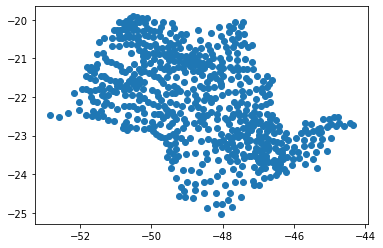

In [26]:
# Intersect
gdf_inter = gpd.sjoin(gdf, gdf_gov, how='inner', op='intersects')

# Convert to Dataframe
df = gdf_inter[['id_municipio', 'regiaogoverno_nome']].copy()

# Results
display(df.head())
gdf_inter.plot()

In [27]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='left',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_regiaogoverno.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,regiaogoverno_nome
0,3500105,Adamantina,Adamantina
1,3500204,Adolfo,São José do Rio Preto
2,3500303,Aguaí,São João da Boa Vista
3,3500402,Águas da Prata,São João da Boa Vista
4,3500501,Águas de Lindóia,Bragança Paulista


<br>

## Regiões Administrativas

In [28]:
# Input
url = 'http://datageo.ambiente.sp.gov.br/geoserver/datageo/RegiaoAdministrativa/wfs?version=1.0.0&request=GetFeature&outputFormat=SHAPE-ZIP&typeName=RegiaoAdministrativa'
filename = 'sp_regioesadm.zip'

# Get Data
get_download(url, filename, shps_path)
unzip(filename, shps_path)

File "sp_regioesadm.zip" download in "../data/shps" directory.
File "RegiaoAdministrativaPolygon.cst" extracted as "sp_regioesadm.cst" in "../data/shps" directory.
File "RegiaoAdministrativaPolygon.shx" extracted as "sp_regioesadm.shx" in "../data/shps" directory.
File "RegiaoAdministrativaPolygon.shp" extracted as "sp_regioesadm.shp" in "../data/shps" directory.
File "RegiaoAdministrativaPolygon.prj" extracted as "sp_regioesadm.prj" in "../data/shps" directory.
File "RegiaoAdministrativaPolygon.dbf" extracted as "sp_regioesadm.dbf" in "../data/shps" directory.
File "wfsrequest.txt" extracted as "sp_regioesadm.txt" in "../data/shps" directory.


In [29]:
def rename_nome(x):
    x = x.title()
    x = x.strip()
    dict_rename = {
        '  '  : ' ',
        ' De '  : ' de ',
        ' Da '  : ' da ',
        ' Do '  : ' do ',
        ' Dos '  : ' dos ',        
        ' Jose '  : ' José ',
        ' Joao '  : ' João ',
        'Jau'  : 'Jaú',
        'Sao ': 'São ',
        'Avare': 'Avaré',
        'Jundiai': 'Jundiaí',
        'Marilia': 'Marília',
        'Taubate': 'Taubaté',
        'Ribeirao': 'Ribeirão',
        'Guaratingueta': 'Guaratinguetá',
        'Fernandopolis': 'Fernandópolis',
    }
    for k, v in dict_rename.items():
        x = x.replace(k, v)
    x = x.replace('  ', ' ')
    return x.strip()

In [30]:
# Lê arquivo
file = 'sp_regioesadm'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Transforma Coordenadas
gdf = gdf.to_crs(epsg=4326)

# Renomeia colunas
gdf.rename(columns={'Nome': 'regiaoadm_nome'}, inplace=True)

# Renomeia Campos Coluna
gdf.loc[:, 'regiaoadm_nome'] = gdf['regiaoadm_nome'].astype(str).apply(lambda x: rename_nome(x))

# Results
display(gdf.head())

# Cria Cópia
gdf_adm = gdf

# Deleta Shapefile
delete_shapefile(shp)

,regiaoadm_nome,geometry
0,Presidente Prudente,"POLYGON ((-51.76840 -21.05116, -51.76776 -21.0..."
1,Araçatuba,"POLYGON ((-51.10467 -20.28636, -51.10212 -20.2..."
2,São José do Rio Preto,"POLYGON ((-50.43823 -19.79598, -50.43705 -19.7..."
3,Marília,"POLYGON ((-50.76320 -21.56327, -50.76293 -21.5..."
4,Sorocaba,"POLYGON ((-48.65221 -22.53407, -48.65203 -22.5..."


,id_municipio,geometry
0,3500105,POINT (-51.03455 -21.58238)
1,3500204,POINT (-49.64157 -21.28052)
2,3500303,POINT (-47.05263 -22.05743)
3,3500402,POINT (-46.70056 -21.91795)
4,3500501,POINT (-46.60940 -22.47578)


<AxesSubplot:>

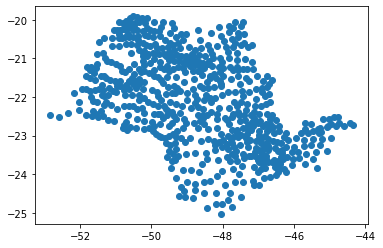

In [31]:
# Lê arquivo
file = 'sp_igc_050k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
gdf = gpd.read_file(shp)

# Renomeia colunas
gdf.rename(
    columns={
        'Cod_ibge'  : 'id_municipio',
        'Cod_Cetesb': 'id_cetesb',
        'Nome'      : 'nome_municipio',
        'Rotulo'    : 'rotulo_municipio',
        'Nome_ugrhi': 'nome_ugrhi',
        'UGRHI'     : 'id_ugrhi',
    },
    inplace=True
)

# Deleta colunas
gdf.drop(['id_cetesb', 'nome_municipio', 'rotulo_municipio', 'nome_ugrhi', 'id_ugrhi'], axis=1, inplace=True)

# Transforma Coordenadas
gdf = gdf.to_crs(epsg=4326)

# Pega centroid
gdf_geometry = gdf.representative_point()
gdf['geometry'] = gdf_geometry

# Results
display(gdf.head())
gdf.plot()

/home/michel/Documents/Conda/envs/pablocarreira-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id_municipio,regiaoadm_nome
0,3500105,Presidente Prudente
9,3500808,Presidente Prudente
15,3501301,Presidente Prudente
26,3502408,Presidente Prudente
100,3508900,Presidente Prudente


<AxesSubplot:>

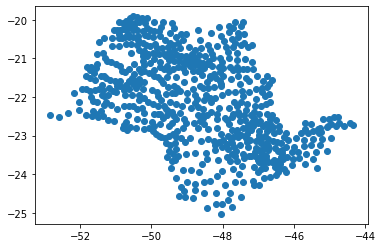

In [32]:
# Intersect
gdf_inter = gpd.sjoin(gdf, gdf_adm, how='inner', op='intersects')

# Convert to Dataframe
df = gdf_inter[['id_municipio', 'regiaoadm_nome']].copy()

# Results
display(df.head())
gdf_inter.plot()

In [33]:
# Lê o arquivo csv com o nome dos municípios
df_mun = pd.read_csv(
    os.path.join(tabs_path, 'tab_municipio_nome.csv'),
    usecols=['id_municipio', 'municipio_nome']
)

# Merge
df = pd.merge(
    df_mun,
    df,
    how='left',
    left_on='id_municipio',
    right_on='id_municipio'
)

# Salva
df.to_csv(
    os.path.join(tabs_path, 'tab_municipio_regiaoadm.csv'),
    index=False,
)

# Resultados
df.head()

,id_municipio,municipio_nome,regiaoadm_nome
0,3500105,Adamantina,Presidente Prudente
1,3500204,Adolfo,São José do Rio Preto
2,3500303,Aguaí,Campinas
3,3500402,Águas da Prata,Campinas
4,3500501,Águas de Lindóia,Campinas


<br>

# Delete Temp Files

In [34]:
# Deleta Shapefile
file = 'sp_ibge_250k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
delete_shapefile(shp)

In [35]:
# Deleta Shapefile
file = 'sp_igc_050k'
shp = os.path.join(shps_path, '{}.shp'.format(file))
delete_shapefile(shp)

In [36]:
import shutil
shutil.rmtree(shps_path, ignore_errors=True, onerror=print('Erro'))

Erro
